## Bibliotecas

In [10]:
!pip install rasterio geojson rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 89.6 MB/s eta 0:00:00


In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import geojson
import rasterio
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from rasterstats import zonal_stats
from io import BytesIO
from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm


## Importando rasters de 2008 e 2022

In [2]:
raster_2008 = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=amazonia_terraclass:terraclass_AMZ.2008.M&"
    "crs=EPSG:4674&"
    "bbox=-73.98318216,-16.66197917,-43.39929216,5.26958083&"
    "width=800&"
    "height=600&"
    "format=GeoTIFF"
)


In [3]:
response = requests.get(raster_2008)
if response.status_code == 200:
    with open("class_2008.tif", "wb") as f:
        f.write(response.content)
    print("Arquivo class_2008.tif baixado com sucesso!")
else:
    print("Erro ao baixar o arquivo. Código de status:", response.status_code)


Arquivo class_2008.tif baixado com sucesso!


In [4]:
raster_2022 = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=amazonia_terraclass:terraclass_AMZ.2022.M&"
    "crs=EPSG:4674&"
    "bbox=-73.98318216,-16.66197917,-43.39929216,5.26958083&"
    "width=800&"
    "height=600&"
    "format=GeoTIFF"
)

response_2022 = requests.get(raster_2022)
response_2022.raise_for_status()
raster_bytes_2022 = BytesIO(response_2022.content)


In [5]:
response = requests.get(raster_2022)
if response.status_code == 200:
    with open("class_2022.tif", "wb") as f:
        f.write(response.content)
    print("Arquivo class_2022.tif baixado com sucesso!")
else:
    print("Erro ao baixar o arquivo. Código de status:", response.status_code)


Arquivo class_2022.tif baixado com sucesso!


In [85]:
# Abre o raster de 2008
src_2008 = rasterio.open("class_2008.tif")

data_2008 = src_2008.read(1)         # Lê a banda 1 como array NumPy
profile_2008 = src_2008.profile      # Metadados (dimensão, CRS, etc.)
nodata_2008 = src_2008.nodata


In [86]:
# Abre o raster de 2022
src_2022 = rasterio.open("class_2022.tif")

data_2022 = src_2022.read(1)
profile_2022 = src_2022.profile
nodata_2022 = src_2022.nodata


In [88]:
# Se os rasters tiverem valor NoData, mascaramos esses pixels para que apareçam em branco
if nodata_2008 is not None:
    data_2008 = np.ma.masked_equal(data_2008, nodata_2008)
if nodata_2022 is not None:
    data_2022 = np.ma.masked_equal(data_2022, nodata_2022)


In [132]:
extent = [src_2008.bounds.left, src_2008.bounds.right, src_2008.bounds.bottom, src_2008.bounds.top]
extent


[-73.98318216, -43.39929216, -16.66197917, 5.26958083]

In [89]:
print(profile_2008)
print(profile_2022)


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 800, 'height': 600, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]'), 'transform': Affine(0.038229862499999996, 0.0, -73.98318216,
       0.0, -0.0365526, 5.26958083), 'blockxsize': 400, 'blockysize': 608, 'tiled': True, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 800, 'height': 600, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","91

## Definindo paleta de cores de uso/cobertura da terra

In [90]:
# Definindo a paleta de cores conforme o QML
palette = {
    1:  ("#005500", "Vegetação natural florestal primária"),
    2:  ("#0fc80f", "Vegetação natural florestal secundária"),
    9:  ("#a8a800", "Silvicultura"),
    10: ("#e6a04b", "Pastagem arbustiva/arbórea"),
    11: ("#ffec87", "Pastagem herbácea"),
    12: ("#ff8828", "Cultura agrícola perene"),
    13: ("#996400", "Cultura agrícola semiperene"),
    16: ("#ad89cd", "Mineração"),
    17: ("#ffa8c0", "Urbanizada"),
    20: ("#e1e1e1", "Outros usos"),
    22: ("#ff0000", "Desflorestamento no ano"),
    23: ("#0000ff", "Corpo d'água"),
    25: ("#ffffff", "Não observado"),
    50: ("#ff00ff", "Não floresta"),
    52: ("#ffff00", "Cultura agrícola temporária"),
}


In [91]:
# Criar uma lista com as chaves ordenadas (classes existentes)
sorted_keys = sorted(palette.keys())
sorted_keys

[1, 2, 9, 10, 11, 12, 13, 16, 17, 20, 22, 23, 25, 50, 52]

In [92]:
# Lista de cores correspondente à ordem das classes
colors = [palette[k][0] for k in sorted_keys]
colors


['#005500',
 '#0fc80f',
 '#a8a800',
 '#e6a04b',
 '#ffec87',
 '#ff8828',
 '#996400',
 '#ad89cd',
 '#ffa8c0',
 '#e1e1e1',
 '#ff0000',
 '#0000ff',
 '#ffffff',
 '#ff00ff',
 '#ffff00']

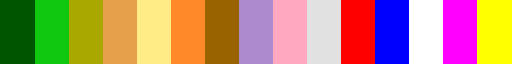

In [93]:
# Criando um colormap discreto
cmap = ListedColormap(colors)
cmap


In [94]:
# Definindo os limites de cada classe (usando k - 0.5 e k + 0.5)
boundaries = [k - 0.5 for k in sorted_keys] + [sorted_keys[-1] + 0.5]
boundaries


[0.5,
 1.5,
 8.5,
 9.5,
 10.5,
 11.5,
 12.5,
 15.5,
 16.5,
 19.5,
 21.5,
 22.5,
 24.5,
 49.5,
 51.5,
 52.5]

In [95]:
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
norm


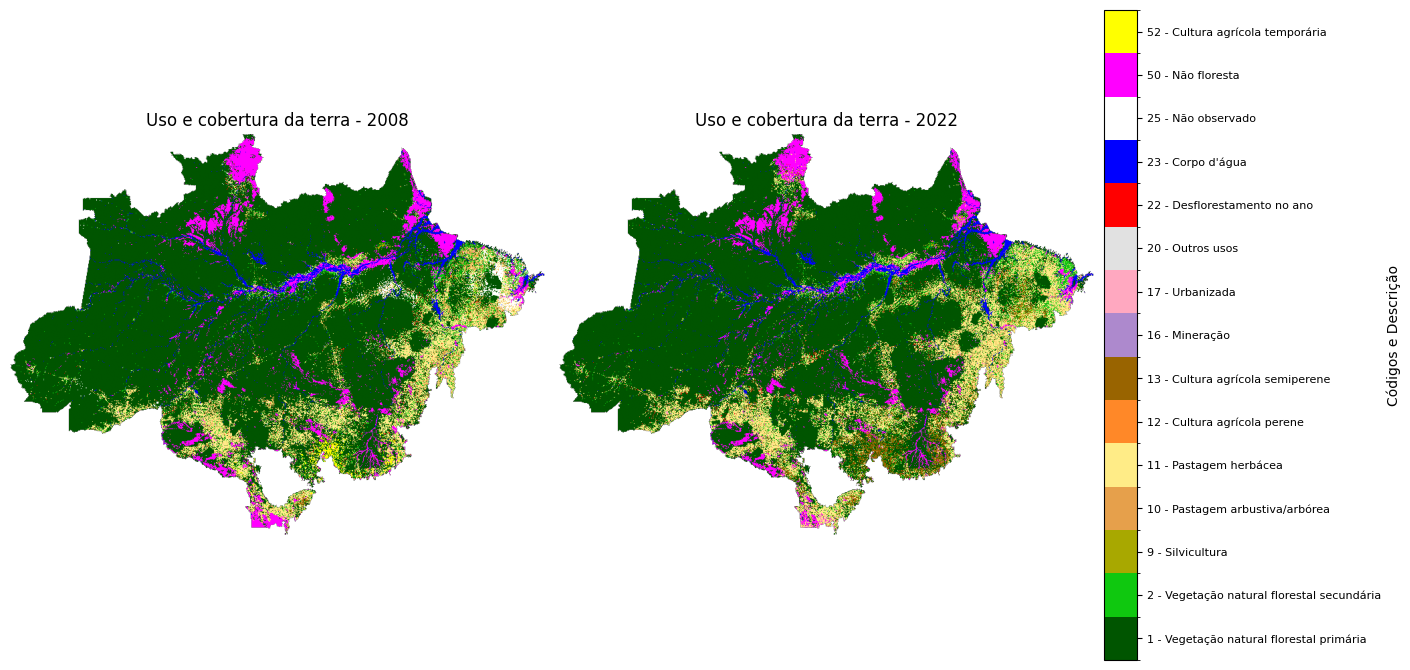

In [142]:
# Cria a figura com constrained_layout para melhor ajuste
fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

# Plot do raster de 2008
im0 = axs[0].imshow(data_2008, cmap=cmap, norm=norm)
axs[0].set_title("Uso e cobertura da terra - 2008", fontsize=12)
axs[0].axis('off')

# Plot do raster de 2022
im1 = axs[1].imshow(data_2022, cmap=cmap, norm=norm)
axs[1].set_title("Uso e cobertura da terra - 2022", fontsize=12)
axs[1].axis('off')

# Calcula as posições centrais para os ticks da colorbar
ticks_center = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(sorted_keys))]

# Adiciona a barra de cores com os ticks centralizados
cbar = fig.colorbar(im1, ax=axs, fraction=0.03, pad=0.04, ticks=ticks_center)
cbar.ax.tick_params(labelsize=8)  # diminui o tamanho dos rótulos dos ticks
cbar.set_label("Códigos e Descrição", fontsize=10)

# Define os rótulos: número da classe e descrição na mesma linha
cbar.ax.set_yticklabels([f"{k} - {palette[k][1]}" for k in sorted_keys])

plt.show()


## Calculando a transição de qualquer pixel para urbano

In [110]:
# Identificando os pixels onde houve mudança para urbano: pixels que não eram 17 em 2008 e que são 17 em 2022
urban_change_bool = (data_2008 != 17) & (data_2022 == 17)
urban_change_bool


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=False)

In [113]:
# Converte o array booleano para binário (0 e 1): 1 = houve transição para urbano, 0 = não houve
urban_change_bin = urban_change_bool.astype(np.uint8)

# Atualiza o profile para refletir o novo tipo de dados e 1 banda
profile_2008.update(
    dtype=rasterio.uint8,
    count=1
)


In [114]:
# Salvando o raster resultante como um novo arquivo TIFF
output_path = "urban_change_2008_2022.tif"
with rasterio.open(output_path, 'w', **profile_2008) as dst:
    dst.write(urban_change_bin, 1)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)
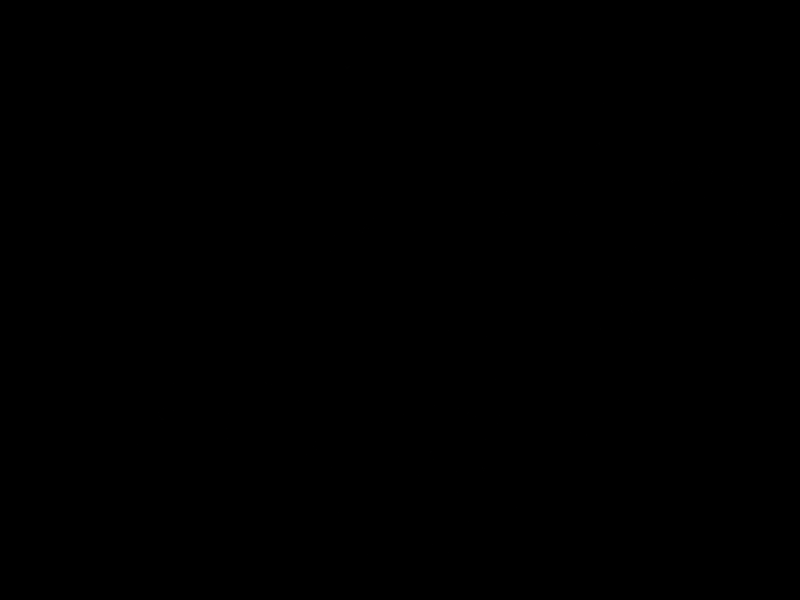

In [143]:
# Criando uma máscara para exibir somente os pixels que tiveram transição para urbano
urban_change_mask = np.ma.masked_where(urban_change_bin == 0, urban_change_bin)

# Visualizando apenas os pixels que mudaram para urbano
plt.figure(figsize=(8, 6))
plt.imshow(urban_change_mask, cmap='Reds', vmin=0, vmax=1)
plt.title("Somente transição para urbano")
plt.colorbar()
plt.axis('off')
plt.show()


In [123]:
# Parâmetros para conectar com a camada vetorial
mun_url = "https://info.dengue.mat.br/geoserver/wfs"

params_AML = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="amazonia_legal_mun_2022",
    outputFormat="json",
)

# Fazendo o request
r_AML = requests.get(mun_url, params=params_AML)

# Baixando e carregando a camada
municipios = gpd.GeoDataFrame.from_features(geojson.loads(r_AML.content), crs="EPSG:4674")


In [125]:
municipios.head()

,geometry,CD_MUN,NM_REGIAO,CD_UF,NM_UF,SIGLA_UF,NM_MUN,AREA_TOT,AREA_INT,PORC_INT
0,"MULTIPOLYGON (((-62.00806 -12.13378, -62.00784...",1100015,Norte,11,Rondônia,RO,Alta Floresta D'Oeste,7067.127,7067.127,100.0
1,"MULTIPOLYGON (((-63.17933 -10.13924, -63.17746...",1100023,Norte,11,Rondônia,RO,Ariquemes,4426.571,4426.571,100.0
2,"MULTIPOLYGON (((-60.52408 -13.32137, -60.37162...",1100031,Norte,11,Rondônia,RO,Cabixi,1314.352,1314.352,100.0
3,"MULTIPOLYGON (((-61.35502 -11.50452, -61.35524...",1100049,Norte,11,Rondônia,RO,Cacoal,3793.000,3793.000,100.0
4,"MULTIPOLYGON (((-60.82134 -13.1191, -60.81774 ...",1100056,Norte,11,Rondônia,RO,Cerejeiras,2783.300,2783.300,100.0


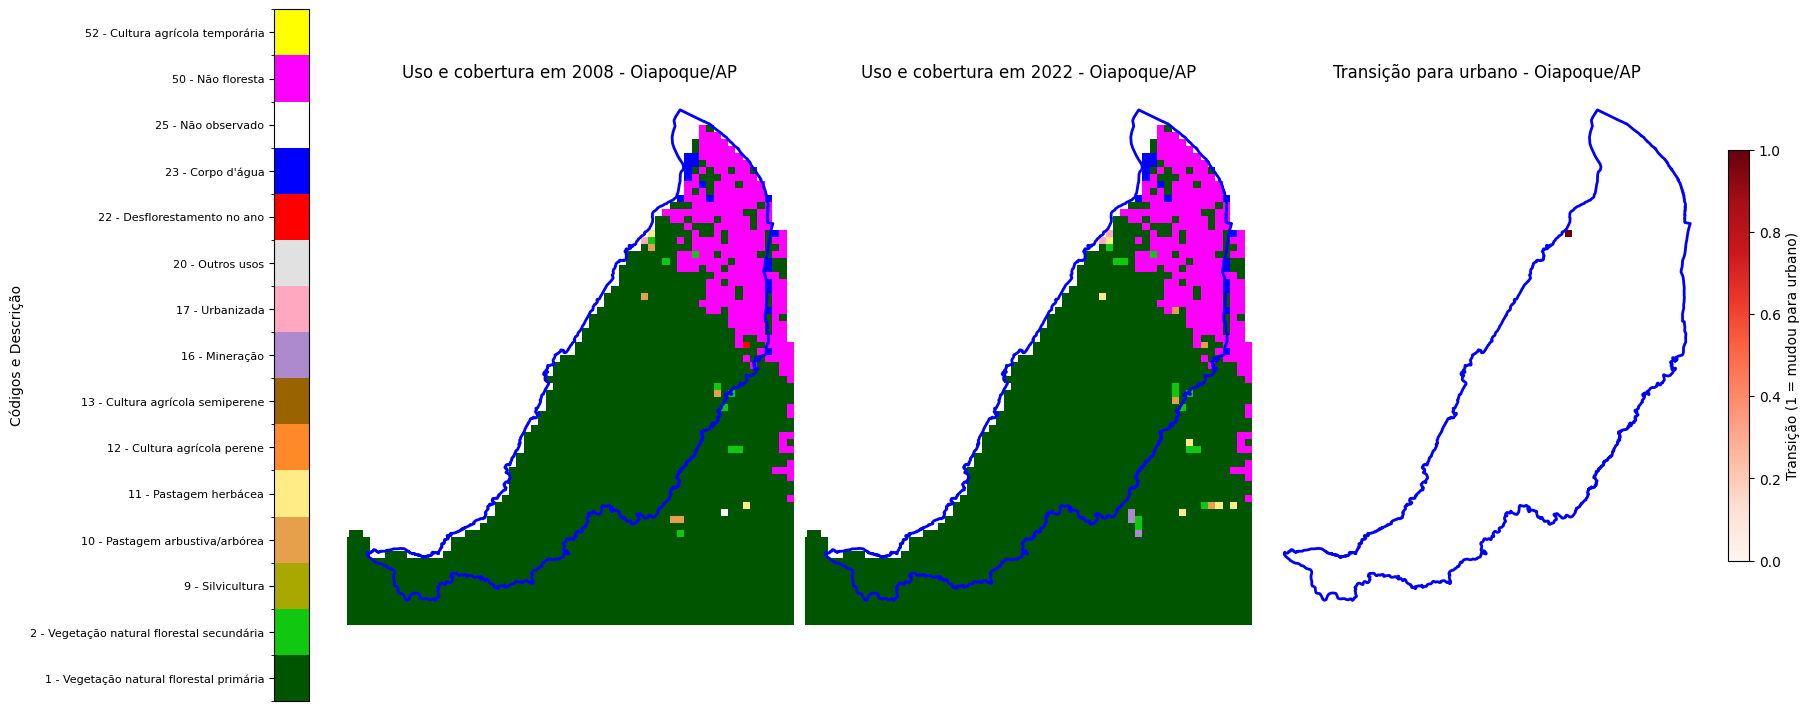

In [147]:
# Filtrar para Oiapoque/AP
municipio_oiapoque = municipios[municipios['NM_MUN'].str.contains("Oiapoque", case=False)]

# Obter os limites (bounding box) do Oiapoque/AP
xmin, ymin, xmax, ymax = municipio_oiapoque.total_bounds
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05

# Figura com três subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 7), constrained_layout=True)

# Subplot 0: Raster de 2008 com zoom em Oiapoque/AP
im0 = axs[0].imshow(data_2008, cmap=cmap, norm=norm, extent=extent)
axs[0].set_title("Uso e cobertura em 2008 - Oiapoque/AP", fontsize=12)
municipio_oiapoque.boundary.plot(ax=axs[0], edgecolor='blue', linewidth=2)
axs[0].set_xlim(xmin - margin_x, xmax + margin_x)
axs[0].set_ylim(ymin - margin_y, ymax + margin_y)
axs[0].axis('off')

# Subplot 1: Raster de 2022 com zoom em Oiapoque/AP
im1 = axs[1].imshow(data_2022, cmap=cmap, norm=norm, extent=extent)
axs[1].set_title("Uso e cobertura em 2022 - Oiapoque/AP", fontsize=12)
municipio_oiapoque.boundary.plot(ax=axs[1], edgecolor='blue', linewidth=2)
axs[1].set_xlim(xmin - margin_x, xmax + margin_x)
axs[1].set_ylim(ymin - margin_y, ymax + margin_y)
axs[1].axis('off')

# Adiciona uma colorbar comum para os subplots de uso/cobertura (im0 e im1)
# Posicionada à esquerda da figura
cbar1 = fig.colorbar(im0, ax=axs[:2], orientation='vertical', fraction=0.046, pad=0.04, ticks=ticks_center, location='left')
cbar1.set_label("Códigos e Descrição", fontsize=10)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.set_yticklabels([f"{k} - {palette[k][1]}" for k in sorted_keys])

# Subplot 2: Pixels que mudaram para urbano (urban_change_mask) com zoom em Oiapoque
im2 = axs[2].imshow(urban_change_mask, cmap='Reds', vmin=0, vmax=1, extent=extent)
axs[2].set_title("Transição para urbano - Oiapoque/AP", fontsize=12)
municipio_oiapoque.boundary.plot(ax=axs[2], edgecolor='blue', linewidth=2)
axs[2].set_xlim(xmin - margin_x, xmax + margin_x)
axs[2].set_ylim(ymin - margin_y, ymax + margin_y)
axs[2].axis('off')

# Adicionar uma colorbar para o subplot de transição
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label("Transição (1 = mudou para urbano)", fontsize=10)

plt.show()


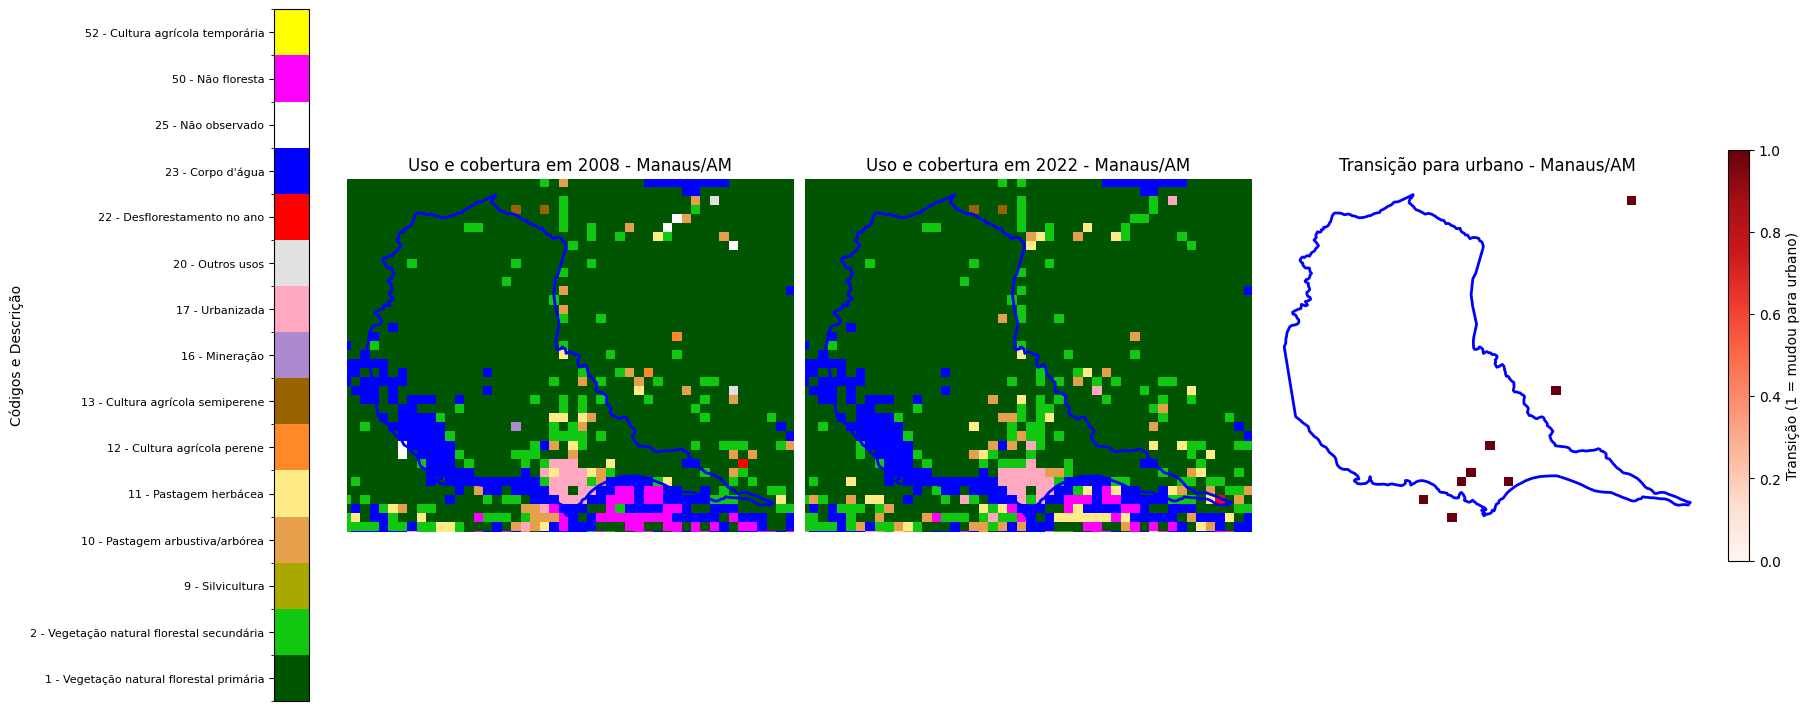

In [148]:
# Filtrar para Manaus/AM
municipio_oiapoque = municipios[municipios['NM_MUN'].str.contains("Manaus", case=False)]

# Obter os limites (bounding box) do Manaus/AM
xmin, ymin, xmax, ymax = municipio_oiapoque.total_bounds
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05

# Figura com três subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 7), constrained_layout=True)

# Subplot 0: Raster de 2008 com zoom em Manaus/AM
im0 = axs[0].imshow(data_2008, cmap=cmap, norm=norm, extent=extent)
axs[0].set_title("Uso e cobertura em 2008 - Manaus/AM", fontsize=12)
municipio_manaus.boundary.plot(ax=axs[0], edgecolor='blue', linewidth=2)
axs[0].set_xlim(xmin - margin_x, xmax + margin_x)
axs[0].set_ylim(ymin - margin_y, ymax + margin_y)
axs[0].axis('off')

# Subplot 1: Raster de 2022 com zoom em Manaus/AM
im1 = axs[1].imshow(data_2022, cmap=cmap, norm=norm, extent=extent)
axs[1].set_title("Uso e cobertura em 2022 - Manaus/AM", fontsize=12)
municipio_manaus.boundary.plot(ax=axs[1], edgecolor='blue', linewidth=2)
axs[1].set_xlim(xmin - margin_x, xmax + margin_x)
axs[1].set_ylim(ymin - margin_y, ymax + margin_y)
axs[1].axis('off')

# Adiciona uma colorbar comum para os subplots de uso/cobertura (im0 e im1)
# Posicionada à esquerda da figura
cbar1 = fig.colorbar(im0, ax=axs[:2], orientation='vertical', fraction=0.046, pad=0.04, ticks=ticks_center, location='left')
cbar1.set_label("Códigos e Descrição", fontsize=10)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.set_yticklabels([f"{k} - {palette[k][1]}" for k in sorted_keys])

# Subplot 2: Pixels que mudaram para urbano (urban_change_mask) com zoom em Manaus/AM
im2 = axs[2].imshow(urban_change_mask, cmap='Reds', vmin=0, vmax=1, extent=extent)
axs[2].set_title("Transição para urbano - Manaus/AM", fontsize=12)
municipio_manaus.boundary.plot(ax=axs[2], edgecolor='blue', linewidth=2)
axs[2].set_xlim(xmin - margin_x, xmax + margin_x)
axs[2].set_ylim(ymin - margin_y, ymax + margin_y)
axs[2].axis('off')

# Adicionar uma colorbar para o subplot de transição
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
cbar.set_label("Transição (1 = mudou para urbano)", fontsize=10)

plt.show()
